In [23]:
import os, datetime
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from rich.progress import Progress
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Load Data
train_data = pd.read_csv('../Dataset/train.csv')
test_data = pd.read_csv('../Dataset/test.csv')

In [7]:
# Split features and labels
train_features = train_data.drop('act', axis=1)
test_features = test_data.drop('act', axis=1)
train_labels = train_data['act']
test_labels = test_data['act']

# Data preparation
# scaler = StandardScaler()
# train_features = scaler.fit_transform(train_features)
# test_features = scaler.transform(test_features)

In [8]:
# Define dataset class
class Data(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
# train_data = Data(torch.FloatTensor(train_features), torch.FloatTensor(train_labels))
# test_data = Data(torch.FloatTensor(test_features), torch.FloatTensor(test_labels))

train_data = Data(torch.FloatTensor(train_features.to_numpy()), torch.FloatTensor(train_labels.to_numpy()))
test_data = Data(torch.FloatTensor(test_features.to_numpy()), torch.FloatTensor(test_labels.to_numpy()))

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.linear = nn.Linear(in_channels, out_channels)
        self.relu = nn.ReLU()
        if in_channels != out_channels:
            self.linear_shortcut = nn.Linear(in_channels, out_channels)
        else:
            self.linear_shortcut = nn.Identity()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.linear(x)
        out = self.relu(out)
        out = self.dropout(out)
        shortcut = self.linear_shortcut(x)
        out += shortcut
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer = nn.Sequential(
            ResidualBlock(train_features.shape[1], 128),  # 增加每层的单元数
            ResidualBlock(128, 128),
            ResidualBlock(128, 64),
            ResidualBlock(64, 32),
            nn.Dropout(0.5),
            nn.Linear(32, 4)  # num_classes是你的类别数量
        )
        
    def forward(self, x):
        x = self.layer(x)
        return nn.functional.softmax(x, dim=1)

In [12]:
# Define hyperparameters
EPOCHS = 600
BATCH_SIZE = 16384
LEARNING_RATE = 1e-05
WEIGHT_DECAY = 1e-05 # L2 regularization

In [13]:
# Check CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create model
model = Net().to(device)

In [14]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [11]:
# Initialize progress
progress = Progress()

# Train model
losses = []
accuracies = []

with progress:
    task1 = progress.add_task("[cyan]Training...", total=EPOCHS)
    for epoch in range(EPOCHS):
        running_loss = 0.0
        correct = 0
        total = 0
        for X, y in DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
        progress.update(task1, advance=1)
        acc = correct/total
        losses.append(running_loss)
        accuracies.append(acc)
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_data)}, Accuracy: {acc}')

Output()

Epoch 1, Loss: 0.00011332256831101023, Accuracy: 0.3272066416091859

Epoch 2, Loss: 0.00011321296528819414, Accuracy: 0.3269588203709058

Epoch 3, Loss: 0.0001131453866049888, Accuracy: 0.33051092478625416

Epoch 4, Loss: 0.00011315513566092662, Accuracy: 0.33158481681880136

Epoch 5, Loss: 0.0001130293236016725, Accuracy: 0.3376977406963777

Epoch 6, Loss: 0.00011282846350675966, Accuracy: 0.34414109289166084

Epoch 7, Loss: 0.00011266032183442603, Accuracy: 0.350584445086944

Epoch 8, Loss: 0.00011259036497242373, Accuracy: 0.3562843335673867

Epoch 9, Loss: 0.00011255119641687558, Accuracy: 0.35806038577506094

Epoch 10, Loss: 0.00011252691732857791, Accuracy: 0.3584321176324811

Epoch 11, Loss: 0.00011249716793667068, Accuracy: 0.35909297426789477

Epoch 12, Loss: 0.00011231188663619586, Accuracy: 0.36264507868324314

Epoch 13, Loss: 0.00011226396362536617, Accuracy: 0.3685101813225393

Epoch 14, Loss: 0.00011209835276856387, Accuracy: 0.37677088926521

Epoch 15, Loss: 0.0001120581059083438, Accuracy: 0.373962248564702

Epoch 16, Loss: 0.00011190798521819825, Accuracy: 0.3841642228739003

Epoch 17, Loss: 0.00011179001671758501, Accuracy: 0.3851142042873074

Epoch 18, Loss: 0.00011185634968808718, Accuracy: 0.3839990087150469

Epoch 19, Loss: 0.00011166368273917462, Accuracy: 0.3906901821486101

Epoch 20, Loss: 0.00011155659576059299, Accuracy: 0.3950270538185122

Epoch 21, Loss: 0.00011147884457760606, Accuracy: 0.39758787328074013

Epoch 22, Loss: 0.00011136132413966471, Accuracy: 0.40407252901573665

Epoch 23, Loss: 0.00011115788891532993, Accuracy: 0.40708768741481144

Epoch 24, Loss: 0.00011104088054901358, Accuracy: 0.42047003428193797

Epoch 25, Loss: 0.00011095986490941718, Accuracy: 0.4183635537565569

Epoch 26, Loss: 0.00011074639012697269, Accuracy: 0.4263764404609475

Epoch 27, Loss: 0.00011078832583880219, Accuracy: 0.4272025112552146

Epoch 28, Loss: 0.00011062372927771867, Accuracy: 0.43323282805336416

Epoch 29, Loss: 0.00011051602190466826, Accuracy: 0.43835446697782

Epoch 30, Loss: 0.00011040317904407082, Accuracy: 0.43728057494527284

Epoch 31, Loss: 0.00011022618936490876, Accuracy: 0.4504151005741192

Epoch 32, Loss: 0.00011014153013874974, Accuracy: 0.44859774482673165

Epoch 33, Loss: 0.00011006303546715342, Accuracy: 0.4539672049894676

Epoch 34, Loss: 0.00010999772171613565, Accuracy: 0.4575606129445293

Epoch 35, Loss: 0.00010980572932311374, Accuracy: 0.4658626244269134

Epoch 36, Loss: 0.00010976779170897187, Accuracy: 0.46937342530254844

Epoch 37, Loss: 0.00010966195536685903, Accuracy: 0.47218206600305646

Epoch 38, Loss: 0.00010952021000204189, Accuracy: 0.47193424476477636

Epoch 39, Loss: 0.00010951507943826046, Accuracy: 0.47354508281359714

Epoch 40, Loss: 0.00010919394652042181, Accuracy: 0.4854818057907563

Epoch 41, Loss: 0.00010914640756331089, Accuracy: 0.48577093056874976

Epoch 42, Loss: 0.0001090877261245902, Accuracy: 0.4906860517946388

Epoch 43, Loss: 0.00010899563693610281, Accuracy: 0.49171864028747264

Epoch 44, Loss: 0.00010876933574420478, Accuracy: 0.4975011358473421

Epoch 45, Loss: 0.00010879324555008057, Accuracy: 0.49684027921192847

Epoch 46, Loss: 0.00010862004224668426, Accuracy: 0.5038205774234852

Epoch 47, Loss: 0.00010847494379747639, Accuracy: 0.5080748420139606

Epoch 48, Loss: 0.00010837586286180126, Accuracy: 0.5101813225393417

Epoch 49, Loss: 0.00010825173473039094, Accuracy: 0.5155507827020775

Epoch 50, Loss: 0.00010800488174077349, Accuracy: 0.5221180455165008

Epoch 51, Loss: 0.00010794962724292792, Accuracy: 0.5263723101069762

Epoch 52, Loss: 0.00010795369919709993, Accuracy: 0.5225723844533476

Epoch 53, Loss: 0.00010770692498773246, Accuracy: 0.5358308207013341

Epoch 54, Loss: 0.00010758852319574422, Accuracy: 0.5340134649539465

Epoch 55, Loss: 0.00010757704589807195, Accuracy: 0.536987319813308

Epoch 56, Loss: 0.00010736719500712758, Accuracy: 0.5419437445789104

Epoch 57, Loss: 0.00010718589210927789, Accuracy: 0.5520218082689686

Epoch 58, Loss: 0.00010707155734769602, Accuracy: 0.5483457932344802

Epoch 59, Loss: 0.00010704193597369505, Accuracy: 0.5489653463301805

Epoch 60, Loss: 0.00010701009890516275, Accuracy: 0.5501218454421544

Epoch 61, Loss: 0.00010664989098332283, Accuracy: 0.5594977489570856

Epoch 62, Loss: 0.00010662598610121267, Accuracy: 0.5634215852298542

Epoch 63, Loss: 0.0001064091877769712, Accuracy: 0.5645780843418281

Epoch 64, Loss: 0.00010634718772021916, Accuracy: 0.5686258312337368

Epoch 65, Loss: 0.00010619706210630798, Accuracy: 0.5742844161744661

Epoch 66, Loss: 0.0001059463291893779, Accuracy: 0.5769278427161207

Epoch 67, Loss: 0.00010583682956563993, Accuracy: 0.5806451612903226

Epoch 68, Loss: 0.00010569341012051023, Accuracy: 0.5883276196770063

Epoch 69, Loss: 0.00010571894969280795, Accuracy: 0.5840733550865309

Epoch 70, Loss: 0.00010550010800583202, Accuracy: 0.5923340630292016

Epoch 71, Loss: 0.00010525205854116766, Accuracy: 0.5927057948866218

Epoch 72, Loss: 0.00010521307216494763, Accuracy: 0.5946470612531494

Epoch 73, Loss: 0.00010508944133386545, Accuracy: 0.5979513444302177

Epoch 74, Loss: 0.00010498920331326841, Accuracy: 0.5990665400024782

Epoch 75, Loss: 0.00010478724029485554, Accuracy: 0.6050142497212011

Epoch 76, Loss: 0.0001047126944832906, Accuracy: 0.603609929370947

Epoch 77, Loss: 0.00010458858604694278, Accuracy: 0.6093511213911033

Epoch 78, Loss: 0.00010438762255295182, Accuracy: 0.6152575275701128

Epoch 79, Loss: 0.0001042801269018233, Accuracy: 0.6180248647309075

Epoch 80, Loss: 0.00010419405455492985, Accuracy: 0.6206682912725621

Epoch 81, Loss: 0.0001038724489555912, Accuracy: 0.6235182355127834

Epoch 82, Loss: 0.00010378282164991638, Accuracy: 0.6199248275577217

Epoch 83, Loss: 0.00010359869251059785, Accuracy: 0.6279377142621123

Epoch 84, Loss: 0.00010338974266876288, Accuracy: 0.6342571558382554

Epoch 85, Loss: 0.00010334095799894878, Accuracy: 0.6355788691090827

Epoch 86, Loss: 0.00010330174020574436, Accuracy: 0.6382635991904506

Epoch 87, Loss: 0.00010302167641698518, Accuracy: 0.6399157407789847

Epoch 88, Loss: 0.00010292094109606002, Accuracy: 0.6438808805914666

Epoch 89, Loss: 0.00010263506726386315, Accuracy: 0.6463177894345545

Epoch 90, Loss: 0.0001025748052963768, Accuracy: 0.6483003593407956

Epoch 91, Loss: 0.00010243549719554411, Accuracy: 0.6479286274833753

Epoch 92, Loss: 0.0001023244613569311, Accuracy: 0.648589484118789

Epoch 93, Loss: 0.00010219328239314555, Accuracy: 0.6580479947131469

Epoch 94, Loss: 0.00010192037775960535, Accuracy: 0.6649456858452769

Epoch 95, Loss: 0.00010190341046326104, Accuracy: 0.661682706207922

Epoch 96, Loss: 0.0001017473615593028, Accuracy: 0.6635000619553095

Epoch 97, Loss: 0.00010150717042457619, Accuracy: 0.6668869522118046

Epoch 98, Loss: 0.00010154767332060876, Accuracy: 0.6648217752261368

Epoch 99, Loss: 0.00010133788151485189, Accuracy: 0.6674238982280781

Epoch 100, Loss: 0.00010098287801327775, Accuracy: 0.6763041592664492

Epoch 101, Loss: 0.00010095411337449557, Accuracy: 0.6769650159018628

Epoch 102, Loss: 0.00010082521903796009, Accuracy: 0.6769237123621494

Epoch 103, Loss: 0.00010057319609443621, Accuracy: 0.6778736937755566

Epoch 104, Loss: 0.00010038105598844554, Accuracy: 0.6865887406550741

Epoch 105, Loss: 0.0001001966708133145, Accuracy: 0.6851018132253934

Epoch 106, Loss: 0.0001000933899055611, Accuracy: 0.6862583123373673

Epoch 107, Loss: 9.996114740840052e-05, Accuracy: 0.6861344017182273

Epoch 108, Loss: 9.986092908286599e-05, Accuracy: 0.6895212919747222

Epoch 109, Loss: 9.960738469576393e-05, Accuracy: 0.6941059848829044

Epoch 110, Loss: 9.94581650547278e-05, Accuracy: 0.6959646441700054

Epoch 111, Loss: 9.930829547662913e-05, Accuracy: 0.6986906777910867

Epoch 112, Loss: 9.919845611306303e-05, Accuracy: 0.7019123538887283

Epoch 113, Loss: 9.902000407551031e-05, Accuracy: 0.700590640617901

Epoch 114, Loss: 9.87626733126425e-05, Accuracy: 0.7052992441452233

Epoch 115, Loss: 9.87070396848438e-05, Accuracy: 0.7098426335136921

Epoch 116, Loss: 9.859185311180878e-05, Accuracy: 0.708892652100285

Epoch 117, Loss: 9.833837765742548e-05, Accuracy: 0.7127338812936269

Epoch 118, Loss: 9.833468975697223e-05, Accuracy: 0.7093882945768453

Epoch 119, Loss: 9.807654164901065e-05, Accuracy: 0.714964272438148

Epoch 120, Loss: 9.797639225619486e-05, Accuracy: 0.7190120193300565

Epoch 121, Loss: 9.757791190415056e-05, Accuracy: 0.7236793193176655

Epoch 122, Loss: 9.763940973680882e-05, Accuracy: 0.71905332286977

Epoch 123, Loss: 9.725537571310874e-05, Accuracy: 0.7250836396679196

Epoch 124, Loss: 9.737664313669083e-05, Accuracy: 0.7210358927760109

Epoch 125, Loss: 9.708215271464994e-05, Accuracy: 0.7221510883482715

Epoch 126, Loss: 9.699342153431891e-05, Accuracy: 0.7298748502746686

Epoch 127, Loss: 9.678255142389012e-05, Accuracy: 0.7296683325761018

Epoch 128, Loss: 9.674879901052964e-05, Accuracy: 0.7296683325761018

Epoch 129, Loss: 9.655290207136696e-05, Accuracy: 0.7315269918632027

Epoch 130, Loss: 9.630564040920262e-05, Accuracy: 0.737639915740779

Epoch 131, Loss: 9.618267428647984e-05, Accuracy: 0.7374333980422122

Epoch 132, Loss: 9.604610872310037e-05, Accuracy: 0.741026805997274

Epoch 133, Loss: 9.560177334178893e-05, Accuracy: 0.7400355210441535

Epoch 134, Loss: 9.578462230204493e-05, Accuracy: 0.741605055553261

Epoch 135, Loss: 9.550369685430134e-05, Accuracy: 0.7413985378546941

Epoch 136, Loss: 9.535564906948399e-05, Accuracy: 0.7436702325389286

Epoch 137, Loss: 9.532894256473311e-05, Accuracy: 0.7436289289992152

Epoch 138, Loss: 9.507841644595927e-05, Accuracy: 0.7483375325265376

Epoch 139, Loss: 9.51056596411633e-05, Accuracy: 0.7479658006691173

Epoch 140, Loss: 9.463324402449157e-05, Accuracy: 0.7519309404815993

Epoch 141, Loss: 9.465596720285168e-05, Accuracy: 0.7513526909256123

Epoch 142, Loss: 9.43598371668576e-05, Accuracy: 0.7546156705629673

Epoch 143, Loss: 9.442808548218796e-05, Accuracy: 0.7566395440089215

Epoch 144, Loss: 9.418789927122698e-05, Accuracy: 0.7550287059601007

Epoch 145, Loss: 9.39117695712023e-05, Accuracy: 0.7577547395811821

Epoch 146, Loss: 9.39324740056561e-05, Accuracy: 0.7573830077237619

Epoch 147, Loss: 9.366686146900677e-05, Accuracy: 0.7590764528520094

Epoch 148, Loss: 9.35986082299108e-05, Accuracy: 0.7650654661104457

Epoch 149, Loss: 9.34181669910455e-05, Accuracy: 0.764528520094172

Epoch 150, Loss: 9.314563656369282e-05, Accuracy: 0.7627111643467845

Epoch 151, Loss: 9.308848149231595e-05, Accuracy: 0.7644459130147454

Epoch 152, Loss: 9.292116701260734e-05, Accuracy: 0.769195820081781

Epoch 153, Loss: 9.276219831563338e-05, Accuracy: 0.7703523191937549

Epoch 154, Loss: 9.262947328944153e-05, Accuracy: 0.7715914253851555

Epoch 155, Loss: 9.253987552636047e-05, Accuracy: 0.7712609970674487

Epoch 156, Loss: 9.226921612994536e-05, Accuracy: 0.7731609598942629

Epoch 157, Loss: 9.229236275214923e-05, Accuracy: 0.7753087439593573

Epoch 158, Loss: 9.200228894787411e-05, Accuracy: 0.7786130271364256

Epoch 159, Loss: 9.19013714476208e-05, Accuracy: 0.7746891908636571

Epoch 160, Loss: 9.168576467466061e-05, Accuracy: 0.7781999917392921

Epoch 161, Loss: 9.156200582567218e-05, Accuracy: 0.7817107926149272

Epoch 162, Loss: 9.136594640224388e-05, Accuracy: 0.7836107554417413

Epoch 163, Loss: 9.144005399866819e-05, Accuracy: 0.7813390607575069

Epoch 164, Loss: 9.118860221195682e-05, Accuracy: 0.784849861633142

Epoch 165, Loss: 9.10097808919822e-05, Accuracy: 0.7886497872867705

Epoch 166, Loss: 9.083756726547656e-05, Accuracy: 0.7856346288876956

Epoch 167, Loss: 9.085200374628954e-05, Accuracy: 0.7870389492379497

Epoch 168, Loss: 9.0701804275894e-05, Accuracy: 0.7887323943661971

Epoch 169, Loss: 9.043371016136958e-05, Accuracy: 0.789062822683904

Epoch 170, Loss: 9.034852901605429e-05, Accuracy: 0.7931931766552394

Epoch 171, Loss: 9.013637872656296e-05, Accuracy: 0.7921192846226922

Epoch 172, Loss: 9.00782290545298e-05, Accuracy: 0.7914997315269918

Epoch 173, Loss: 8.987692089694509e-05, Accuracy: 0.7935236049729462

Epoch 174, Loss: 8.966164401628179e-05, Accuracy: 0.7965800669117343

Epoch 175, Loss: 8.958805833901375e-05, Accuracy: 0.7983561191194085

Epoch 176, Loss: 8.951307923607379e-05, Accuracy: 0.7932344801949527

Epoch 177, Loss: 8.936229383756885e-05, Accuracy: 0.797240923547148

Epoch 178, Loss: 8.911559348468577e-05, Accuracy: 0.7975300483251415

Epoch 179, Loss: 8.903773397885509e-05, Accuracy: 0.8015777952170501

Epoch 180, Loss: 8.899644328032248e-05, Accuracy: 0.8002973854859361

Epoch 181, Loss: 8.890362045075695e-05, Accuracy: 0.8028995084878774

Epoch 182, Loss: 8.884259037583307e-05, Accuracy: 0.8023212589318904

Epoch 183, Loss: 8.863349282102934e-05, Accuracy: 0.8043038288381315

Epoch 184, Loss: 8.841097800489705e-05, Accuracy: 0.8048820783941184

Epoch 185, Loss: 8.84393438186636e-05, Accuracy: 0.8033951509644377

Epoch 186, Loss: 8.815507021029492e-05, Accuracy: 0.8102515385568543

Epoch 187, Loss: 8.808339987785506e-05, Accuracy: 0.8053364173309653

Epoch 188, Loss: 8.788280074252037e-05, Accuracy: 0.8095080748420139

Epoch 189, Loss: 8.78288362712686e-05, Accuracy: 0.8118623766056751

Epoch 190, Loss: 8.76298816736527e-05, Accuracy: 0.8126058403205154

Epoch 191, Loss: 8.755139192582201e-05, Accuracy: 0.8123167155425219

Epoch 192, Loss: 8.743240420572436e-05, Accuracy: 0.8112841270496881

Epoch 193, Loss: 8.747099175692875e-05, Accuracy: 0.8128536615587956

Epoch 194, Loss: 8.729997460547002e-05, Accuracy: 0.8161992482755772

Epoch 195, Loss: 8.708375728557231e-05, Accuracy: 0.8188426748172318

Epoch 196, Loss: 8.689799837983184e-05, Accuracy: 0.816281855355004

Epoch 197, Loss: 8.673297837490457e-05, Accuracy: 0.8192970137540787

Epoch 198, Loss: 8.682458011059507e-05, Accuracy: 0.8169840155301309

Epoch 199, Loss: 8.655779571772696e-05, Accuracy: 0.8160340341167238

Epoch 200, Loss: 8.63639963027206e-05, Accuracy: 0.8217339225971666

Epoch 201, Loss: 8.634830426167321e-05, Accuracy: 0.8202469951674859

Epoch 202, Loss: 8.642021093486307e-05, Accuracy: 0.8177274792449712

Epoch 203, Loss: 8.602474885114699e-05, Accuracy: 0.8255338482507951

Epoch 204, Loss: 8.601369007355287e-05, Accuracy: 0.8239643137416877

Epoch 205, Loss: 8.587506145237646e-05, Accuracy: 0.823427367725414

Epoch 207, Loss: 8.562178294861816e-05, Accuracy: 0.8254512411713684

Epoch 208, Loss: 8.561805565803991e-05, Accuracy: 0.8261120978067821

Epoch 209, Loss: 8.5502736143333e-05, Accuracy: 0.8257403659493618

Epoch 210, Loss: 8.53280261676554e-05, Accuracy: 0.8257403659493618

Epoch 211, Loss: 8.531798168578008e-05, Accuracy: 0.8260707942670686

Epoch 212, Loss: 8.522540012073017e-05, Accuracy: 0.8268555615216224

Epoch 213, Loss: 8.504354083736483e-05, Accuracy: 0.8264012225847756

Epoch 214, Loss: 8.47618620534806e-05, Accuracy: 0.8325141464623518

Epoch 215, Loss: 8.492480422931406e-05, Accuracy: 0.8297881128412705

Epoch 216, Loss: 8.463286924163262e-05, Accuracy: 0.8287142208087233

Epoch 217, Loss: 8.449117311447173e-05, Accuracy: 0.8329684853991988

Epoch 218, Loss: 8.446924266237726e-05, Accuracy: 0.8335467349551856

Epoch 219, Loss: 8.425624548519841e-05, Accuracy: 0.8339184668126058

Epoch 220, Loss: 8.407194893784862e-05, Accuracy: 0.8373053570691008

Epoch 221, Loss: 8.418839107111806e-05, Accuracy: 0.8367271075131139

Epoch 222, Loss: 8.406937380842666e-05, Accuracy: 0.8359010367188469

Epoch 223, Loss: 8.40553903140512e-05, Accuracy: 0.8344554128288795

Epoch 224, Loss: 8.389724880970227e-05, Accuracy: 0.837553178307381

Epoch 225, Loss: 8.373556219410323e-05, Accuracy: 0.8379662137045145

Epoch 226, Loss: 8.354066477936246e-05, Accuracy: 0.8389161951179216

Epoch 227, Loss: 8.36817060456952e-05, Accuracy: 0.8362314650365537

Epoch 228, Loss: 8.338983014320126e-05, Accuracy: 0.8406096402461691

Epoch 229, Loss: 8.33303855208087e-05, Accuracy: 0.8395770517533353

Epoch 230, Loss: 8.333795334857457e-05, Accuracy: 0.8430878526289703

Epoch 231, Loss: 8.315229784191223e-05, Accuracy: 0.8436247986452439

Epoch 232, Loss: 8.303510237250214e-05, Accuracy: 0.8406922473255958

Epoch 233, Loss: 8.283480358687058e-05, Accuracy: 0.84246829953327

Epoch 234, Loss: 8.30080118140325e-05, Accuracy: 0.8408987650241626

Epoch 235, Loss: 8.275519614424297e-05, Accuracy: 0.8454834579323448

Epoch 236, Loss: 8.270613820543668e-05, Accuracy: 0.8428813349304035

Epoch 237, Loss: 8.269601740519416e-05, Accuracy: 0.8445334765189376

Epoch 238, Loss: 8.246221239448337e-05, Accuracy: 0.8443269588203709

Epoch 239, Loss: 8.226000318778924e-05, Accuracy: 0.8487877411094131

Epoch 240, Loss: 8.217633117663807e-05, Accuracy: 0.8463921358060386

Epoch 241, Loss: 8.231430247510353e-05, Accuracy: 0.8463921358060386

Epoch 242, Loss: 8.2284924827501e-05, Accuracy: 0.8465160464251786

Epoch 243, Loss: 8.193597755764581e-05, Accuracy: 0.8488703481888398

Epoch 244, Loss: 8.205405684298562e-05, Accuracy: 0.8461443145677584

Epoch 245, Loss: 8.18963067780039e-05, Accuracy: 0.8485812234108463

Epoch 246, Loss: 8.17790916135313e-05, Accuracy: 0.8504398826979472

Epoch 247, Loss: 8.178338513715645e-05, Accuracy: 0.8504811862376606

Epoch 248, Loss: 8.175479529205394e-05, Accuracy: 0.8501920614596671

Epoch 249, Loss: 8.143094199370739e-05, Accuracy: 0.8519681136673413

Epoch 250, Loss: 8.151050758432719e-05, Accuracy: 0.852050720746768

Epoch 251, Loss: 8.121712993331757e-05, Accuracy: 0.8548180579075627

Epoch 252, Loss: 8.131492576616452e-05, Accuracy: 0.8512659534922142

Epoch 253, Loss: 8.120726763077038e-05, Accuracy: 0.8545702366692826

Epoch 254, Loss: 8.103692995896792e-05, Accuracy: 0.8550245756061294

Epoch 255, Loss: 8.094903335691035e-05, Accuracy: 0.8584114658626244

Epoch 256, Loss: 8.090812178833089e-05, Accuracy: 0.8542811118912891

Epoch 257, Loss: 8.08729193259938e-05, Accuracy: 0.8560984676386766

Epoch 258, Loss: 8.08378350340317e-05, Accuracy: 0.8553963074635497

Epoch 259, Loss: 8.066894494932305e-05, Accuracy: 0.856718020734377

Epoch 260, Loss: 8.062834111609516e-05, Accuracy: 0.8571723596712238

Epoch 261, Loss: 8.063139385078275e-05, Accuracy: 0.8560158605592499

Epoch 262, Loss: 8.051401374016173e-05, Accuracy: 0.856965841972657

Epoch 263, Loss: 8.042359370822126e-05, Accuracy: 0.8615918384205526

Epoch 264, Loss: 8.034157362043732e-05, Accuracy: 0.8591549295774648

Epoch 265, Loss: 8.035719426688314e-05, Accuracy: 0.8580397340052043

Epoch 266, Loss: 8.007081082494408e-05, Accuracy: 0.8587831977200446

Epoch 267, Loss: 8.00735927525223e-05, Accuracy: 0.8621287844368263

Epoch 268, Loss: 8.001362128720782e-05, Accuracy: 0.8625418198339597

Epoch 269, Loss: 8.004974449371682e-05, Accuracy: 0.862335302135393

Epoch 270, Loss: 7.992568037125963e-05, Accuracy: 0.8636570154062203

Epoch 271, Loss: 7.972256765357328e-05, Accuracy: 0.8639874437239271

Epoch 272, Loss: 7.967436644998576e-05, Accuracy: 0.8640700508033539

Epoch 273, Loss: 7.953097654744982e-05, Accuracy: 0.8615505348808393

Epoch 274, Loss: 7.941686581720389e-05, Accuracy: 0.8659700136301681

Epoch 275, Loss: 7.948847460257342e-05, Accuracy: 0.8675395481392756

Epoch 276, Loss: 7.932657134128687e-05, Accuracy: 0.8663004419478749

Epoch 277, Loss: 7.923087795636187e-05, Accuracy: 0.8672504233612821

Epoch 278, Loss: 7.927623814718366e-05, Accuracy: 0.8666721738052952

Epoch 279, Loss: 7.91237269688271e-05, Accuracy: 0.8666308702655817

Epoch 280, Loss: 7.91412408031558e-05, Accuracy: 0.8680764941555491

Epoch 281, Loss: 7.889220166160076e-05, Accuracy: 0.8693569038866631

Epoch 282, Loss: 7.901656120999547e-05, Accuracy: 0.8684895295526827

Epoch 283, Loss: 7.889995166869477e-05, Accuracy: 0.870513402998637

Epoch 284, Loss: 7.875403833627592e-05, Accuracy: 0.8733633472388583

Epoch 285, Loss: 7.862123452983408e-05, Accuracy: 0.8711742596340506

Epoch 286, Loss: 7.864524034913955e-05, Accuracy: 0.8690264755689563

Epoch 287, Loss: 7.865879547590561e-05, Accuracy: 0.8703894923794969

Epoch 288, Loss: 7.867475093841395e-05, Accuracy: 0.8750567923671059

Epoch 289, Loss: 7.840372472145975e-05, Accuracy: 0.8718764198091776

Epoch 290, Loss: 7.846731515450871e-05, Accuracy: 0.8744785428111189

Epoch 291, Loss: 7.828495610893243e-05, Accuracy: 0.8752220065259593

Epoch 292, Loss: 7.817002803359272e-05, Accuracy: 0.8739415967948453

Epoch 293, Loss: 7.82525848118298e-05, Accuracy: 0.8716285985708975

Epoch 294, Loss: 7.803216998173664e-05, Accuracy: 0.8743546321919788

Epoch 295, Loss: 7.816503533524881e-05, Accuracy: 0.8742307215728388

Epoch 296, Loss: 7.803402377949452e-05, Accuracy: 0.876006773780513

Epoch 297, Loss: 7.796031993185148e-05, Accuracy: 0.8765024162570733

Epoch 298, Loss: 7.794125018758523e-05, Accuracy: 0.8761719879393665

Epoch 299, Loss: 7.787119977403606e-05, Accuracy: 0.8749328817479658

Epoch 300, Loss: 7.752019190826675e-05, Accuracy: 0.8799306100532815

Epoch 301, Loss: 7.765020886336476e-05, Accuracy: 0.8775763082896204

Epoch 302, Loss: 7.762535369448894e-05, Accuracy: 0.8778654330676139

Epoch 303, Loss: 7.770727284507757e-05, Accuracy: 0.8794762711164347

Epoch 304, Loss: 7.765358164281799e-05, Accuracy: 0.8784023790838875

Epoch 305, Loss: 7.751066195989924e-05, Accuracy: 0.8783197720044608

Epoch 306, Loss: 7.740019481621593e-05, Accuracy: 0.8800132171327083

Epoch 307, Loss: 7.750892387063356e-05, Accuracy: 0.8792284498781545

Epoch 308, Loss: 7.75422749970956e-05, Accuracy: 0.8798480029738549

Epoch 309, Loss: 7.737820281705115e-05, Accuracy: 0.879269753417868

Epoch 310, Loss: 7.723957173399192e-05, Accuracy: 0.8805501631489818

Epoch 311, Loss: 7.705506592660307e-05, Accuracy: 0.8816240551815291

Epoch 312, Loss: 7.693672568168512e-05, Accuracy: 0.8823675188963694

Epoch 313, Loss: 7.708284581226023e-05, Accuracy: 0.8843913923423238

Epoch 314, Loss: 7.691060510504365e-05, Accuracy: 0.8808392879269753

Epoch 315, Loss: 7.689467426136343e-05, Accuracy: 0.8845979100408905

Epoch 316, Loss: 7.692813371066922e-05, Accuracy: 0.8849696418983107

Epoch 317, Loss: 7.676086846861686e-05, Accuracy: 0.8853826772954442

Epoch 318, Loss: 7.658595661854863e-05, Accuracy: 0.8880261038370988

Epoch 319, Loss: 7.675857399383553e-05, Accuracy: 0.8840609640246169

Epoch 320, Loss: 7.658719248372055e-05, Accuracy: 0.8845979100408905

Epoch 321, Loss: 7.653530337967979e-05, Accuracy: 0.8852174631365908

Epoch 322, Loss: 7.654437049407852e-05, Accuracy: 0.883028375531783

Epoch 323, Loss: 7.656255396053223e-05, Accuracy: 0.8864565693279914

Epoch 324, Loss: 7.658325347122042e-05, Accuracy: 0.8860848374705712

Epoch 325, Loss: 7.648114688156864e-05, Accuracy: 0.8863739622485647

Epoch 326, Loss: 7.628523270922627e-05, Accuracy: 0.8875717649002519

Epoch 328, Loss: 7.620627766554401e-05, Accuracy: 0.8897608525050597

Epoch 329, Loss: 7.599490779290426e-05, Accuracy: 0.8904630126801867

Epoch 330, Loss: 7.616198346998005e-05, Accuracy: 0.8912477799347404

Epoch 331, Loss: 7.59036851871669e-05, Accuracy: 0.8914129940935939

Epoch 332, Loss: 7.592520204294885e-05, Accuracy: 0.8908760480773202

Epoch 333, Loss: 7.588775926725232e-05, Accuracy: 0.89025649498162

Epoch 334, Loss: 7.586713853681414e-05, Accuracy: 0.8901738879021932

Epoch 335, Loss: 7.580017532431194e-05, Accuracy: 0.8902977985213333

Epoch 336, Loss: 7.565955750182296e-05, Accuracy: 0.8931064392218413

Epoch 337, Loss: 7.577018959165471e-05, Accuracy: 0.891784725951014

Epoch 338, Loss: 7.554959996788186e-05, Accuracy: 0.8934781710792615

Epoch 339, Loss: 7.569385645316783e-05, Accuracy: 0.8901325843624799

Epoch 340, Loss: 7.550110580023964e-05, Accuracy: 0.8914956011730205

Epoch 341, Loss: 7.5605319761579e-05, Accuracy: 0.8935607781586882

Epoch 342, Loss: 7.541019339173666e-05, Accuracy: 0.8965346330180497

Epoch 343, Loss: 7.549069203594242e-05, Accuracy: 0.8934781710792615

Epoch 344, Loss: 7.542535612797935e-05, Accuracy: 0.8946346701912354

Epoch 345, Loss: 7.528146892511526e-05, Accuracy: 0.8963694188591962

Epoch 346, Loss: 7.526964942573206e-05, Accuracy: 0.8942629383338152

Epoch 347, Loss: 7.529375125846723e-05, Accuracy: 0.8952542232869357

Epoch 348, Loss: 7.528859361397487e-05, Accuracy: 0.8946346701912354

Epoch 349, Loss: 7.527194143863058e-05, Accuracy: 0.8953781339060758

Epoch 350, Loss: 7.513364763351667e-05, Accuracy: 0.8982280781462971

Epoch 351, Loss: 7.503541112364626e-05, Accuracy: 0.8985172029242906

Epoch 352, Loss: 7.499717315980126e-05, Accuracy: 0.8972367931931766

Epoch 353, Loss: 7.501204047010643e-05, Accuracy: 0.8975259179711701

Epoch 354, Loss: 7.491625107175173e-05, Accuracy: 0.8979389533683036

Epoch 355, Loss: 7.497892568439441e-05, Accuracy: 0.8964933294783363

Epoch 356, Loss: 7.496875318461283e-05, Accuracy: 0.8952542232869357

Epoch 357, Loss: 7.487346601035189e-05, Accuracy: 0.9002106480525381

Epoch 358, Loss: 7.490414599396227e-05, Accuracy: 0.8994671843376978

Epoch 359, Loss: 7.487657044457856e-05, Accuracy: 0.89740200735203

Epoch 360, Loss: 7.464026416093018e-05, Accuracy: 0.9026888604353394

Epoch 361, Loss: 7.46461160563757e-05, Accuracy: 0.9002106480525381

Epoch 362, Loss: 7.466902141406395e-05, Accuracy: 0.899962826814258

Epoch 363, Loss: 7.447251638984656e-05, Accuracy: 0.9030605922927595

Epoch 364, Loss: 7.444578526626756e-05, Accuracy: 0.9029366816736194

Epoch 365, Loss: 7.441087084421954e-05, Accuracy: 0.9015736648630788

Epoch 366, Loss: 7.434879200721751e-05, Accuracy: 0.9011193259262319

Epoch 367, Loss: 7.437154965193701e-05, Accuracy: 0.9014497542439387

Epoch 368, Loss: 7.441752531346195e-05, Accuracy: 0.9018214861013589

Epoch 369, Loss: 7.430787797675523e-05, Accuracy: 0.902069307339639

Epoch 370, Loss: 7.423921852699517e-05, Accuracy: 0.9047953409607203

Epoch 371, Loss: 7.412074287852253e-05, Accuracy: 0.9056214117549874

Epoch 372, Loss: 7.430669134923956e-05, Accuracy: 0.9029779852133328

Epoch 373, Loss: 7.428924398574681e-05, Accuracy: 0.9057453223741274

Epoch 374, Loss: 7.406646821003638e-05, Accuracy: 0.90405187724588

Epoch 375, Loss: 7.396015180077509e-05, Accuracy: 0.9049192515798604

Epoch 376, Loss: 7.384587858626354e-05, Accuracy: 0.906860517946388

Epoch 377, Loss: 7.387891951549117e-05, Accuracy: 0.9050431621990005

Epoch 378, Loss: 7.392358053159421e-05, Accuracy: 0.9077278922803684

Epoch 379, Loss: 7.382302000434872e-05, Accuracy: 0.9062409648506877

Epoch 380, Loss: 7.36538246461713e-05, Accuracy: 0.9078931064392218

Epoch 381, Loss: 7.385524358848259e-05, Accuracy: 0.9082235347569286

Epoch 382, Loss: 7.372118914557195e-05, Accuracy: 0.9095865515674694

Epoch 383, Loss: 7.363729556496763e-05, Accuracy: 0.9061996613109744

Epoch 384, Loss: 7.368290686783632e-05, Accuracy: 0.9070670356449547

Epoch 385, Loss: 7.371645248304053e-05, Accuracy: 0.9068192144066747

Epoch 386, Loss: 7.35976420185054e-05, Accuracy: 0.9082235347569286

Epoch 387, Loss: 7.362586750495164e-05, Accuracy: 0.9084300524554955

Epoch 388, Loss: 7.351556530741677e-05, Accuracy: 0.9108256577588699

Epoch 389, Loss: 7.347497378360294e-05, Accuracy: 0.9088843913923423

Epoch 390, Loss: 7.348399412222824e-05, Accuracy: 0.908966998471769

Epoch 391, Loss: 7.340711690763978e-05, Accuracy: 0.9087191772334889

Epoch 392, Loss: 7.328001728367467e-05, Accuracy: 0.9098756763454628

Epoch 393, Loss: 7.328465054712795e-05, Accuracy: 0.9111560860765767

Epoch 394, Loss: 7.327138592253377e-05, Accuracy: 0.9118582462517038

Epoch 395, Loss: 7.318039227189798e-05, Accuracy: 0.9115691214737103

Epoch 396, Loss: 7.312325197181797e-05, Accuracy: 0.9135929949196646

Epoch 397, Loss: 7.321081375781303e-05, Accuracy: 0.9108669612985832

Epoch 398, Loss: 7.31177004260756e-05, Accuracy: 0.9137995126182313

Epoch 399, Loss: 7.319189418839835e-05, Accuracy: 0.9117343356325637

Epoch 400, Loss: 7.300459660590003e-05, Accuracy: 0.9136756019990914

Epoch 401, Loss: 7.303215246022125e-05, Accuracy: 0.9126017099665441

Epoch 402, Loss: 7.304083798278403e-05, Accuracy: 0.9136756019990914

Epoch 403, Loss: 7.296016454489857e-05, Accuracy: 0.9134690843005245

Epoch 404, Loss: 7.297691027178975e-05, Accuracy: 0.9147494940316385

Epoch 405, Loss: 7.262825104222363e-05, Accuracy: 0.9155342612861922

Epoch 406, Loss: 7.269430335808517e-05, Accuracy: 0.9170211887158729

Epoch 407, Loss: 7.283492364245697e-05, Accuracy: 0.9139234232373714

Epoch 408, Loss: 7.275114330846203e-05, Accuracy: 0.9145842798727851

Epoch 409, Loss: 7.264829323020085e-05, Accuracy: 0.9149560117302052

Epoch 410, Loss: 7.260060163635554e-05, Accuracy: 0.9179298665895668

Epoch 411, Loss: 7.258547336647222e-05, Accuracy: 0.9173516170335798

Epoch 412, Loss: 7.24889724839847e-05, Accuracy: 0.9179298665895668

Epoch 413, Loss: 7.247182793207788e-05, Accuracy: 0.9187559373838338

Epoch 414, Loss: 7.251780851736845e-05, Accuracy: 0.9187972409235472

Epoch 415, Loss: 7.259943224201956e-05, Accuracy: 0.9153690471273388

Epoch 416, Loss: 7.234816017275351e-05, Accuracy: 0.9194994010986741

Epoch 417, Loss: 7.262059951044214e-05, Accuracy: 0.9137995126182313

Epoch 418, Loss: 7.232029904496354e-05, Accuracy: 0.9183015984469869

Epoch 419, Loss: 7.235592248926158e-05, Accuracy: 0.9189211515426872

Epoch 420, Loss: 7.232767238398722e-05, Accuracy: 0.9199950435752344

Epoch 421, Loss: 7.242327221736536e-05, Accuracy: 0.9177233488909999

Epoch 422, Loss: 7.217783234848232e-05, Accuracy: 0.9216471851637685

Epoch 423, Loss: 7.227013079700877e-05, Accuracy: 0.9202428648135145

Epoch 424, Loss: 7.212535731633215e-05, Accuracy: 0.9180950807484202

Epoch 425, Loss: 7.223149893191376e-05, Accuracy: 0.9206972037503615

Epoch 426, Loss: 7.224406438178917e-05, Accuracy: 0.9197472223369543

Epoch 427, Loss: 7.21822341949512e-05, Accuracy: 0.9213580603857751

Epoch 428, Loss: 7.212659318150407e-05, Accuracy: 0.9216471851637685

Epoch 429, Loss: 7.201751700160987e-05, Accuracy: 0.9210689356077816

Epoch 430, Loss: 7.218109926697461e-05, Accuracy: 0.9196646152575275

Epoch 431, Loss: 7.187909764047252e-05, Accuracy: 0.9218537028623353

Epoch 432, Loss: 7.193714391342755e-05, Accuracy: 0.9223906488786089

Epoch 433, Loss: 7.201268678753159e-05, Accuracy: 0.9197472223369543

Epoch 434, Loss: 7.184979631123719e-05, Accuracy: 0.9232580232125893

Epoch 435, Loss: 7.195489655038907e-05, Accuracy: 0.9210689356077816

Epoch 436, Loss: 7.181869288378305e-05, Accuracy: 0.9218950064020487

Epoch 437, Loss: 7.175339636594496e-05, Accuracy: 0.9254471108173971

Epoch 438, Loss: 7.173180319179582e-05, Accuracy: 0.9235471479905828

Epoch 439, Loss: 7.16484561491759e-05, Accuracy: 0.9266449134690843

Epoch 440, Loss: 7.159922834045554e-05, Accuracy: 0.9245797364834166

Epoch 441, Loss: 7.165739278378557e-05, Accuracy: 0.9235471479905828

Epoch 442, Loss: 7.162026020532342e-05, Accuracy: 0.9254884143571104

Epoch 443, Loss: 7.164462792140234e-05, Accuracy: 0.9251166824996903

Epoch 444, Loss: 7.16305090234722e-05, Accuracy: 0.9254471108173971

Epoch 445, Loss: 7.160383698508069e-05, Accuracy: 0.9255710214365371

Epoch 446, Loss: 7.1575092041361e-05, Accuracy: 0.9252405931188303

Epoch 447, Loss: 7.156456010668878e-05, Accuracy: 0.9262318780719507

Epoch 448, Loss: 7.135196175452556e-05, Accuracy: 0.9264796993102309

Epoch 449, Loss: 7.138342215498753e-05, Accuracy: 0.9273470736442113

Epoch 450, Loss: 7.125065281490505e-05, Accuracy: 0.9290405187724587

Epoch 451, Loss: 7.13589165734711e-05, Accuracy: 0.9258188426748172

Epoch 452, Loss: 7.133982713414235e-05, Accuracy: 0.9285035727561852

Epoch 453, Loss: 7.125198469350666e-05, Accuracy: 0.928834001073892

Epoch 454, Loss: 7.134775932056448e-05, Accuracy: 0.927553591342778

Epoch 455, Loss: 7.119997003344245e-05, Accuracy: 0.927553591342778

Epoch 456, Loss: 7.128331215229674e-05, Accuracy: 0.927884019660485

Epoch 457, Loss: 7.115050096020646e-05, Accuracy: 0.9283796621370451

Epoch 458, Loss: 7.118628442688732e-05, Accuracy: 0.9288753046136053

Epoch 459, Loss: 7.109548526499373e-05, Accuracy: 0.9288753046136053

Epoch 460, Loss: 7.106864089480534e-05, Accuracy: 0.9299491966461526

Epoch 461, Loss: 7.113008456604173e-05, Accuracy: 0.9285448762958985

Epoch 462, Loss: 7.085972059556412e-05, Accuracy: 0.9325926231878072

Epoch 463, Loss: 7.083075654427411e-05, Accuracy: 0.9308578745198464

Epoch 464, Loss: 7.093518222753535e-05, Accuracy: 0.9299905001858659

Epoch 465, Loss: 7.095230954626246e-05, Accuracy: 0.9312296063772665

Epoch 466, Loss: 7.095496591781725e-05, Accuracy: 0.9324274090289538

Epoch 467, Loss: 7.083133508673507e-05, Accuracy: 0.9326339267275205

Epoch 468, Loss: 7.093938466149641e-05, Accuracy: 0.9294948577093057

Epoch 469, Loss: 7.079494107311668e-05, Accuracy: 0.9311469992978398

Epoch 470, Loss: 7.075354451362313e-05, Accuracy: 0.9318904630126802

Epoch 471, Loss: 7.077949768223336e-05, Accuracy: 0.9323034984098137

Epoch 472, Loss: 7.079948817067151e-05, Accuracy: 0.9312709099169799

Epoch 473, Loss: 7.079671609062456e-05, Accuracy: 0.9327578373466606

Epoch 474, Loss: 7.066044102941697e-05, Accuracy: 0.9334599975217877

Epoch 475, Loss: 7.067115021965169e-05, Accuracy: 0.9332947833629343

Epoch 476, Loss: 7.058565395333639e-05, Accuracy: 0.9345338895543348

Epoch 477, Loss: 7.054739383254607e-05, Accuracy: 0.936309941762009

Epoch 478, Loss: 7.059371169578196e-05, Accuracy: 0.9327578373466606

Epoch 479, Loss: 7.066367101966707e-05, Accuracy: 0.9336665152203544

Epoch 480, Loss: 7.053869846245204e-05, Accuracy: 0.9332534798232208

Epoch 481, Loss: 7.045354439784768e-05, Accuracy: 0.9339969435380612

Epoch 482, Loss: 7.041909527165124e-05, Accuracy: 0.9363512453017223

Epoch 483, Loss: 7.043526491796427e-05, Accuracy: 0.9347404072529015

Epoch 484, Loss: 7.029895539039731e-05, Accuracy: 0.9355664780471686

Epoch 485, Loss: 7.035383568205536e-05, Accuracy: 0.9367642806988559

Epoch 486, Loss: 7.032551664406224e-05, Accuracy: 0.9380033868902565

Epoch 487, Loss: 7.02907179305064e-05, Accuracy: 0.9365990665400025

Epoch 488, Loss: 7.030820960788979e-05, Accuracy: 0.934781710792615

Epoch 489, Loss: 7.023229498948106e-05, Accuracy: 0.9378381727314031

Epoch 490, Loss: 7.019923436519092e-05, Accuracy: 0.9358969063648754

Epoch 491, Loss: 7.026270662786486e-05, Accuracy: 0.9355251745074553

Epoch 493, Loss: 7.011096109506302e-05, Accuracy: 0.9390359753830904

Epoch 494, Loss: 7.020673572212085e-05, Accuracy: 0.9360621205237288

Epoch 495, Loss: 7.020918037175374e-05, Accuracy: 0.9365990665400025

Epoch 496, Loss: 7.011341805410998e-05, Accuracy: 0.9365164594605758

Epoch 497, Loss: 7.013082356559492e-05, Accuracy: 0.9355251745074553

Epoch 498, Loss: 7.008365635278869e-05, Accuracy: 0.937714262112263

Epoch 499, Loss: 7.002225207167731e-05, Accuracy: 0.9367642806988559

Epoch 500, Loss: 7.008402563521058e-05, Accuracy: 0.9371773160959894

Epoch 501, Loss: 6.991593320053319e-05, Accuracy: 0.9384990293668167

Epoch 502, Loss: 6.997285193116006e-05, Accuracy: 0.9373012267151295

Epoch 503, Loss: 6.997369143319915e-05, Accuracy: 0.9379620833505431

Epoch 504, Loss: 6.988279871975867e-05, Accuracy: 0.9398620461773574

Epoch 505, Loss: 6.98561316051328e-05, Accuracy: 0.9403576886539177

Epoch 506, Loss: 6.988463036057123e-05, Accuracy: 0.9389946718433769

Epoch 507, Loss: 6.98329234358586e-05, Accuracy: 0.9406881169716245

Epoch 508, Loss: 6.98544895292968e-05, Accuracy: 0.9393251001610838

Epoch 509, Loss: 6.984933188480444e-05, Accuracy: 0.9395729213993639

Epoch 510, Loss: 6.965472251035276e-05, Accuracy: 0.9392837966213704

Epoch 511, Loss: 6.969644403837756e-05, Accuracy: 0.9408533311304779

Epoch 512, Loss: 6.966587483949375e-05, Accuracy: 0.9407707240510512

Epoch 513, Loss: 6.965915882318103e-05, Accuracy: 0.9410598488290447

Epoch 514, Loss: 6.96172378826484e-05, Accuracy: 0.9420098302424518

Epoch 515, Loss: 6.964199703809453e-05, Accuracy: 0.9419685267027385

Epoch 516, Loss: 6.948813428607386e-05, Accuracy: 0.9422576514807319

Epoch 517, Loss: 6.962151417309386e-05, Accuracy: 0.9392837966213704

Epoch 518, Loss: 6.961077051649976e-05, Accuracy: 0.9408946346701912

Epoch 519, Loss: 6.9471292545753e-05, Accuracy: 0.9412663665276114

Epoch 520, Loss: 6.930917017689612e-05, Accuracy: 0.9431663293544257

Epoch 521, Loss: 6.950767424995731e-05, Accuracy: 0.9416380983850317

Epoch 522, Loss: 6.943787987222065e-05, Accuracy: 0.9423402585601586

Epoch 523, Loss: 6.945554388140091e-05, Accuracy: 0.9421750444013052

Epoch 524, Loss: 6.942942330475944e-05, Accuracy: 0.9427119904175788

Epoch 525, Loss: 6.956237482417004e-05, Accuracy: 0.9411837594481847

Epoch 526, Loss: 6.930960100638833e-05, Accuracy: 0.9432489364338524

Epoch 527, Loss: 6.935189369122564e-05, Accuracy: 0.9436619718309859

Epoch 528, Loss: 6.931103874595087e-05, Accuracy: 0.942959811655859

Epoch 529, Loss: 6.92262711969481e-05, Accuracy: 0.9424641691792986

Epoch 530, Loss: 6.921166976998668e-05, Accuracy: 0.943785882450126

Epoch 531, Loss: 6.918948820584533e-05, Accuracy: 0.943785882450126

Epoch 532, Loss: 6.925949184362106e-05, Accuracy: 0.9430011151955723

Epoch 533, Loss: 6.914414524820321e-05, Accuracy: 0.9454380240386601

Epoch 534, Loss: 6.915967726686778e-05, Accuracy: 0.9454380240386601

Epoch 535, Loss: 6.922967844276071e-05, Accuracy: 0.9443641320061129

Epoch 536, Loss: 6.89883179136981e-05, Accuracy: 0.9451488992606666

Epoch 537, Loss: 6.91767061102824e-05, Accuracy: 0.944488042625253

Epoch 538, Loss: 6.929950482497393e-05, Accuracy: 0.9433315435132791

Epoch 539, Loss: 6.917395126341514e-05, Accuracy: 0.9425880797984387

Epoch 540, Loss: 6.909424534547501e-05, Accuracy: 0.9452728098798067

Epoch 541, Loss: 6.892712043074297e-05, Accuracy: 0.9475858081037545

Epoch 542, Loss: 6.899509547708114e-05, Accuracy: 0.9451488992606666

Epoch 543, Loss: 6.886514745470189e-05, Accuracy: 0.9484531824377349

Epoch 544, Loss: 6.901415783569895e-05, Accuracy: 0.9453967204989467

Epoch 545, Loss: 6.889314398604655e-05, Accuracy: 0.9471314691669076

Epoch 546, Loss: 6.895210361752504e-05, Accuracy: 0.9458510594357936

Epoch 547, Loss: 6.906334871617714e-05, Accuracy: 0.9453141134195201

Epoch 548, Loss: 6.894491738159512e-05, Accuracy: 0.946594523150634

Epoch 549, Loss: 6.8870374031913e-05, Accuracy: 0.9483705753583082

Epoch 550, Loss: 6.882150319620046e-05, Accuracy: 0.9472553797860477

Epoch 551, Loss: 6.882241409284111e-05, Accuracy: 0.9470901656271943

Epoch 552, Loss: 6.893727323546205e-05, Accuracy: 0.9464293089917806

Epoch 553, Loss: 6.891816902483644e-05, Accuracy: 0.947296683325761

Epoch 554, Loss: 6.871436697996257e-05, Accuracy: 0.9489901284540085

Epoch 555, Loss: 6.877027633863628e-05, Accuracy: 0.9489488249142951

Epoch 556, Loss: 6.860928397399038e-05, Accuracy: 0.9499814134071289

Epoch 557, Loss: 6.879237666064481e-05, Accuracy: 0.9473379868654743

Epoch 558, Loss: 6.874153631868221e-05, Accuracy: 0.9472140762463344

Epoch 559, Loss: 6.870405661474348e-05, Accuracy: 0.9486183965965883

Epoch 560, Loss: 6.864949390596826e-05, Accuracy: 0.9485357895171617

Epoch 561, Loss: 6.87318291147522e-05, Accuracy: 0.9482466647391682

Epoch 562, Loss: 6.866637996017974e-05, Accuracy: 0.9473792904051878

Epoch 563, Loss: 6.852470106619854e-05, Accuracy: 0.9501879311056958

Epoch 564, Loss: 6.855532196462142e-05, Accuracy: 0.949857502787989

Epoch 565, Loss: 6.848949368009583e-05, Accuracy: 0.9498161992482755

Epoch 566, Loss: 6.843031001728138e-05, Accuracy: 0.9504770558836892

Epoch 567, Loss: 6.844920989163357e-05, Accuracy: 0.9508487877411094

Epoch 568, Loss: 6.845177763540709e-05, Accuracy: 0.9502705381851224

Epoch 569, Loss: 6.844555891942252e-05, Accuracy: 0.9503118417248358

Epoch 570, Loss: 6.847538216781412e-05, Accuracy: 0.9507661806616827

Epoch 571, Loss: 6.83199462726762e-05, Accuracy: 0.9517574656148032

Epoch 572, Loss: 6.844360910823494e-05, Accuracy: 0.9508900912808228

Epoch 573, Loss: 6.843710727572693e-05, Accuracy: 0.9510966089793895

Epoch 574, Loss: 6.844432797801622e-05, Accuracy: 0.9503118417248358

Epoch 575, Loss: 6.838836938168626e-05, Accuracy: 0.9495683780099955

Epoch 576, Loss: 6.834552769698173e-05, Accuracy: 0.9514683408368098

Epoch 577, Loss: 6.827190262958869e-05, Accuracy: 0.9522531080913634

Epoch 578, Loss: 6.83547966857711e-05, Accuracy: 0.9509726983602494

Epoch 579, Loss: 6.833062099655156e-05, Accuracy: 0.9510140018999629

Epoch 580, Loss: 6.84080053589994e-05, Accuracy: 0.9495270744702821

Epoch 581, Loss: 6.826545003473692e-05, Accuracy: 0.9507661806616827

Epoch 582, Loss: 6.832526147766857e-05, Accuracy: 0.9503531452645492

Epoch 583, Loss: 6.815534478782706e-05, Accuracy: 0.9517574656148032

Epoch 584, Loss: 6.811654059093517e-05, Accuracy: 0.9520052868530833

Epoch 585, Loss: 6.818189127019511e-05, Accuracy: 0.9517161620750898

Epoch 586, Loss: 6.816243008656168e-05, Accuracy: 0.9519226797736566

Epoch 587, Loss: 6.811684832628674e-05, Accuracy: 0.9506422700425426

Epoch 588, Loss: 6.818351857473424e-05, Accuracy: 0.9514683408368098

Epoch 589, Loss: 6.818057908665602e-05, Accuracy: 0.9520465903927967

Epoch 590, Loss: 6.80247123620259e-05, Accuracy: 0.9525422328693569

Epoch 591, Loss: 6.799282113207174e-05, Accuracy: 0.9537400355210441

Epoch 592, Loss: 6.807114593375399e-05, Accuracy: 0.9537400355210441

Epoch 593, Loss: 6.802528844260406e-05, Accuracy: 0.9536161249019041

Epoch 594, Loss: 6.805734461870666e-05, Accuracy: 0.9530791788856305

Epoch 595, Loss: 6.80495823021986e-05, Accuracy: 0.952913964726777

Epoch 596, Loss: 6.801975905380699e-05, Accuracy: 0.9535748213621907

Epoch 597, Loss: 6.797364306496174e-05, Accuracy: 0.9536574284416175

Epoch 598, Loss: 6.797990117107131e-05, Accuracy: 0.9532856965841973

Epoch 599, Loss: 6.794654512084366e-05, Accuracy: 0.9540291602990376

Epoch 600, Loss: 6.803451804126842e-05, Accuracy: 0.9523770187105035

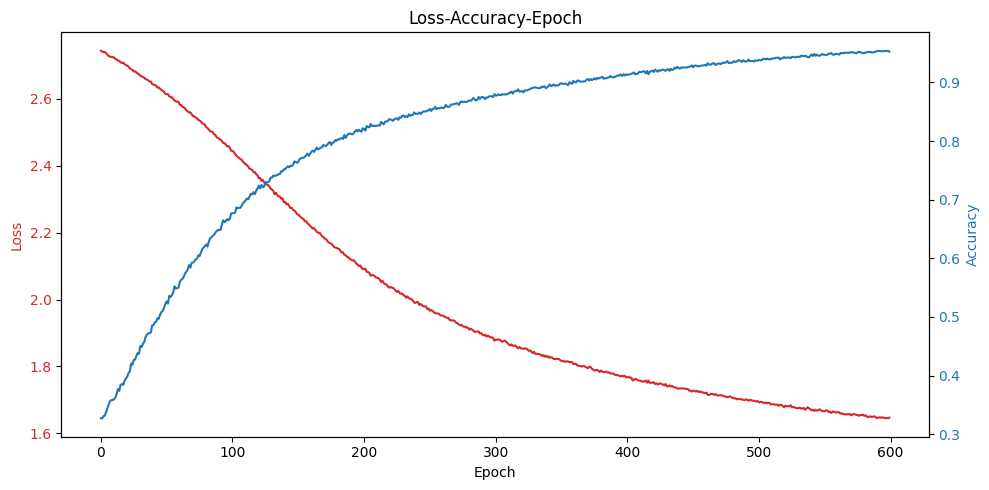

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot loss and accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Create another axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot(accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Loss-Accuracy-Epoch")

fig.tight_layout()  
plt.show()
plt.savefig("Plot/Loss-Accuracy-Epoch.png")

In [15]:
# Define the name of the model
now = datetime.datetime.now()
filename = f'Epochs_{EPOCHS}_Batch_size_{BATCH_SIZE}_Learning_rate_{LEARNING_RATE}_Weight_decay_{WEIGHT_DECAY}.bin'

# Save the model
if not os.path.exists("ckpt"):
    os.makedirs("ckpt")
torch.save(model.state_dict(), f"ckpt/{filename}")

In [16]:
# Test the model
model.load_state_dict(torch.load(f"ckpt/{filename}"))
model.eval()
correct = 0
total = 0
y_true = []
y_pred_list = []
with torch.no_grad():
    for X, y in DataLoader(dataset=test_data, batch_size=BATCH_SIZE):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        _, predicted = torch.max(y_pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        y_true.extend(y.cpu().tolist())
        y_pred_list.extend(predicted.cpu().tolist())

accuracy = correct / total
f1 = f1_score(y_true, y_pred_list, average='weighted')

print(f'Accuracy: {accuracy}, F1 Score: {f1}')

Accuracy: 0.8155294117647058, F1 Score: 0.7966269541367352


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 353, 354, 355, 356, 357, 358, 359, 380, 382, 384, 483, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1249, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1307, 1308, 1309, 1310, 1311, 1314, 1421, 1422, 1423, 1424, 1429, 1430, 1431, 1453, 1454, 1455, 1456, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 22

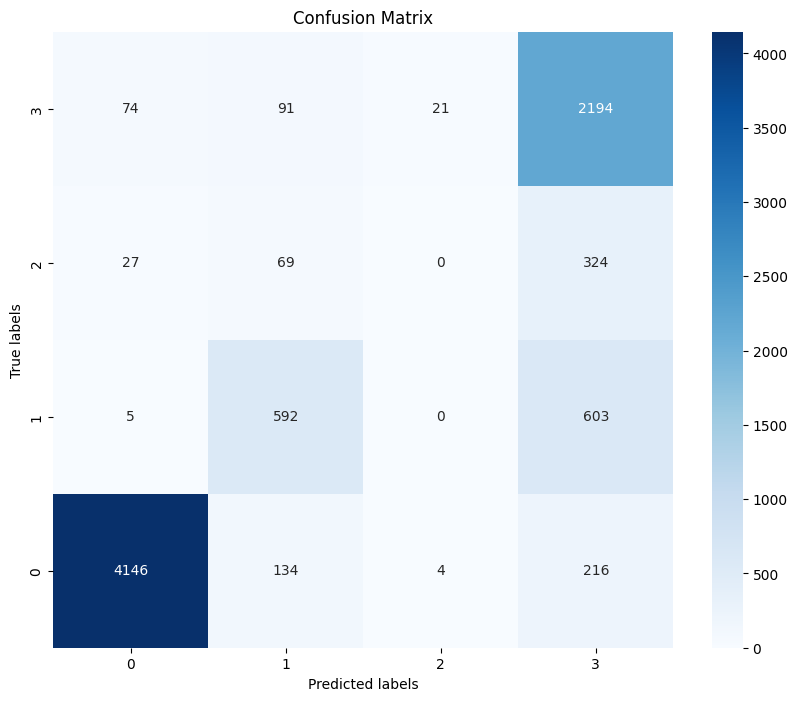

<Figure size 640x480 with 0 Axes>

In [25]:
# Check the error classification
error_index = []
for i in range(len(y_true)):
    if y_true[i] != y_pred_list[i]:
        error_index.append(i)
print(error_index)
# Print the error classification
print(test_features.iloc[error_index])
print(test_labels.iloc[error_index])
print(pd.Series(y_pred_list)[error_index])

# Make confusion matrix
cm = confusion_matrix(y_true, y_pred_list)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')

plt.ylabel('True labels')
plt.title('Confusion Matrix')
ax.invert_yaxis()  # Invert y axis
plt.show()
plt.savefig("Plot/Confusion-Matrix.png")